In [6]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import time

In [7]:
global QUIET, MAX_ITER, ABSTOL, RELTOL
QUIET = False
MAX_ITER = 1000
ABSTOL = 1e-4
RELTOL = 1e-2

In [8]:
m, n = 1000, 3000
p = 100 / n
x0 = sci.sparse.rand(n, 1, p).toarray()  # nx1 ndarray with p% non-zero elements
A = np.random.randn(m, n) 
A = A * sci.sparse.diags([1 / np.sqrt(np.sum(A**2, axis=0))], [0])  # normalize columns
b = A @ x0 + np.sqrt(0.001) * np.random.randn(m, 1)

# lambda (l1 parameter)
lambda_max = np.max(np.abs(A.T @ b))
lamb = 0.1 * lambda_max

# pentalty parameter and l1 soft thresholding
rho, alpha = 1.0, 1.0

In [9]:
# data processing
Atb = A.T @ b

In [10]:
def soft_threshold(x, lamb):
    return np.maximum(0, np.abs(x) - lamb) * np.sign(x)

def objective_f(x, z, A, b, lamb):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lamb * np.linalg.norm(z, 1)

## ADMM solver

In [11]:
x = np.zeros((n, 1))
z = np.zeros((n, 1))
u = np.zeros((n, 1))

history = {'objval': [], 'r_norm': [], 's_norm': [], 'eps_pri': [], 'eps_dual': []}

time_start = time.time()
for k in range(MAX_ITER):
    # x-update
    q = Atb + rho * (z - u) # temporary value  
    # print(A.T @ A + rho * np.eye(n), q) 
    x = sci.linalg.solve(A.T @ A + rho * np.eye(n), q)
    
    # z-update with relaxation
    zold = z
    x_hat = alpha * x + (1 - alpha) * zold # x_hat = x when alpha = 1.0
    z = soft_threshold(x_hat + u, lamb / rho)
    
    # u-update
    u = u + x_hat - z
    
    # diagnostics, reporting, termination checks
    # objective values: residual & target function value & dual variable convergence
    history['objval'] = np.append(history['objval'], objective_f(x, z, A, b, lamb))
    history['r_norm'] = np.append(history['r_norm'], np.linalg.norm(x - z))
    history['s_norm'] = np.append(history['s_norm'], np.linalg.norm(-rho * (z - zold)))
    history['eps_pri'] = np.append(history['eps_pri'], np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(x), np.linalg.norm(-z)))
    history['eps_dual'] = np.append(history['eps_dual'], np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * u))
    
    # history reporting
    if not QUIET:
        print('iter: %d, objval: %f, r_norm: %f, s_norm: %f' % (k, history['objval'][k], history['r_norm'][k], history['s_norm'][k]))
    
    # termination checks
    if history['r_norm'][k] < history['eps_pri'][k] and history['s_norm'][k] < history['eps_dual'][k]:
        break

time_end = time.time()
print('Optimization finished. Elapsed time: %f' % (time_end - time_start))

iter: 0, objval: 1.305374, r_norm: 2.065166, s_norm: 0.493797
iter: 1, objval: 3.789847, r_norm: 1.087477, s_norm: 1.171003
iter: 2, objval: 5.164982, r_norm: 0.460195, s_norm: 1.144265
iter: 3, objval: 5.487121, r_norm: 0.443689, s_norm: 0.821251
iter: 4, objval: 5.445645, r_norm: 0.412983, s_norm: 0.560513
iter: 5, objval: 5.343081, r_norm: 0.347992, s_norm: 0.394359
iter: 6, objval: 5.270333, r_norm: 0.292966, s_norm: 0.268565
iter: 7, objval: 5.200504, r_norm: 0.226568, s_norm: 0.181862
iter: 8, objval: 5.132277, r_norm: 0.169996, s_norm: 0.124843
iter: 9, objval: 5.088188, r_norm: 0.132764, s_norm: 0.080894
iter: 10, objval: 5.056190, r_norm: 0.096552, s_norm: 0.057506
iter: 11, objval: 5.035271, r_norm: 0.071549, s_norm: 0.044568
iter: 12, objval: 5.023931, r_norm: 0.053685, s_norm: 0.037014
iter: 13, objval: 5.019702, r_norm: 0.040936, s_norm: 0.031489
Optimization finished. Elapsed time: 8.609191


## Visualize the result

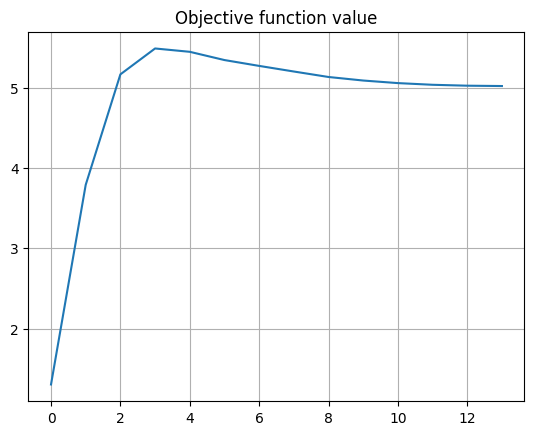

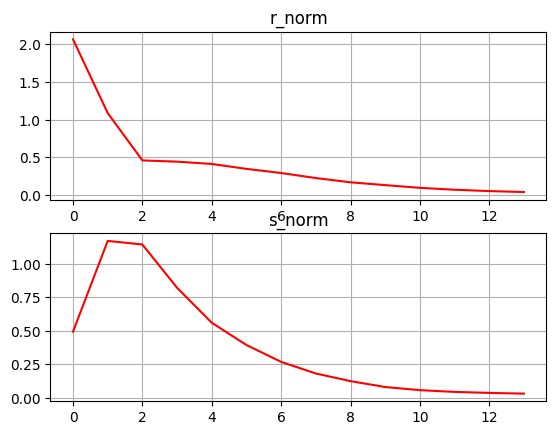

In [12]:
LEN = np.size(history['objval'])
plt.figure()
plt.plot(range(LEN), history['objval'], label='Objective function value')
plt.title('Objective function value')
plt.grid()
plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(range(LEN), history['r_norm'], label='r_norm', color='r')
plt.title('r_norm')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(range(LEN), history['s_norm'], label='s_norm', color='r')
plt.title('s_norm')
plt.grid()
plt.show()